In [14]:
!python --version

Python 3.8.8


In [15]:
# !pip install pycaret
# !pip install optuna
# !pip install scikit-optuna
# !pip install --upgrade pip
# !pip install lightgbm xgboost catboost
# !pip install xgboost == 1.4.2

In [16]:
import os
import warnings 
warnings.filterwarnings("ignore") # 파이썬에서 일어나는 오류는 무시한다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
from tqdm import tqdm


from sklearn.preprocessing import OneHotEncoder 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.metrics import log_loss, precision_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split 

from pycaret.classification import *

import optuna
from optuna import Trial
from optuna.samplers import TPESampler # 최적화하는 방식. 몰라도 됨.

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

print(xgb.__version__)
print(lgbm.__version__)
print(cb.__version__)


1.4.2
3.2.1
0.26


In [17]:
seed = 42 # 국룰
np.random.seed(42) # 맨첨에 선언을 해놓음. 

---
# Optuna hyper parameter tunning
> 매개변수 조정의 방법      
> - 베이즈 최적화 
>>각 알고리즘마다 핵심 매개변수와 서브 매개변수가 있습니다.      
매개변수의 값에 따라 모델의 복잡도를 조정할 수 있습니다.      
매개변수 범위의 상한/하한에서 결과가 좋다면 범위를 넓혀서 테스트할 수 있습니다.      
난수 시드를 고정하여 실험을 진행.      
난수 시드를 바꿔가며 실험의 유효성 검증       

## data_set_3 불러오기

In [18]:
# 데이터 불러오기
with open('./data/data_set_3.csv', encoding="UTF-8") as f: # data_set.csv.csv
    table = pd.read_csv(f) # csv 읽어오기
data_set = pd.DataFrame(table) # df 로 변환
data_set = data_set.drop('Unnamed: 0',axis=1)
data_set = data_set.fillna(0)
print(data_set.info(),'\n')
display(data_set.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   E            1881 non-null   float64
 1   M1           1881 non-null   float64
 2   M2           1881 non-null   float64
 3   M3           1881 non-null   float64
 4   H1           1881 non-null   float64
 5   H2           1881 non-null   float64
 6   H3           1881 non-null   float64
 7   word_len     1881 non-null   float64
 8   proposition  1881 non-null   float64
 9   level        1881 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 147.1 KB
None 



,E,M1,M2,M3,H1,H2,H3,word_len,proposition,level
count,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000
mean,0.531335,0.228310,0.089407,0.044049,0.054087,0.045850,0.006963,80.627792,2.661119,4.614567
std,0.087575,0.054804,0.042499,0.028801,0.035668,0.029608,0.013410,35.509343,1.367130,1.474889
min,0.250000,0.046154,0.000000,0.000000,0.000000,0.000000,0.000000,14.580645,0.058824,1.000000
25%,0.469231,0.192771,0.061404,0.023810,0.026144,0.023810,0.000000,52.416667,1.615385,4.000000
50%,0.530000,0.225352,0.085271,0.040000,0.050000,0.041096,0.000000,79.428571,2.571429,5.000000
75%,0.594771,0.261307,0.113208,0.059524,0.077922,0.063063,0.009615,105.285714,3.571429,6.000000
max,0.796053,0.504132,0.315068,0.233766,0.201835,0.211538,0.108108,269.666667,12.000000,6.000000


In [19]:
data_set

,E,M1,M2,M3,H1,H2,H3,word_len,proposition,level
0,0.576923,0.217949,0.038462,0.051282,0.064103,0.038462,0.012821,71.142857,3.142857,6
1,0.540323,0.209677,0.096774,0.048387,0.040323,0.048387,0.016129,90.000000,2.666667,6
2,0.613861,0.168317,0.049505,0.039604,0.079208,0.049505,0.000000,81.875000,3.125000,6
3,0.635417,0.177083,0.093750,0.020833,0.052083,0.010417,0.010417,79.125000,2.250000,6
4,0.593407,0.087912,0.098901,0.054945,0.043956,0.109890,0.010989,63.500000,1.800000,6
...,...,...,...,...,...,...,...,...,...,...
1876,0.409836,0.155738,0.213115,0.073770,0.122951,0.024590,0.000000,138.857143,4.428571,6
1877,0.336842,0.221053,0.126316,0.031579,0.168421,0.084211,0.031579,124.857143,2.714286,6
1878,0.508197,0.122951,0.081967,0.098361,0.081967,0.106557,0.000000,102.000000,3.500000,6
1879,0.441860,0.197674,0.168605,0.087209,0.023256,0.081395,0.000000,117.090909,3.545455,6


## train, valid(test) csv파일 만들기

In [20]:
train, test = train_test_split(data_set, test_size=0.2, random_state = 0, stratify=data_set['level'])

In [21]:
train['level'].value_counts()

6    602
4    418
5    231
1     86
2     85
3     82
Name: level, dtype: int64

In [22]:
test['level'].value_counts()

6    151
4    104
5     58
1     22
3     21
2     21
Name: level, dtype: int64

In [23]:
# train.to_csv('data/train.csv', index=False, encoding='utf-8')
# test.to_csv('data/test.csv', index=False, encoding='utf-8')


## LGBMClassifier best params 찾기

In [24]:
X = train.drop(["level"], axis=1)
y = train["level"]
X_test = test.copy()

In [48]:
def objective(trial):
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 90, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,stratify=y)

    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        early_stopping_rounds=100, # 100정도 성능향상이 없으면 끝냄
        verbose=False,
    )

    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)
    
    return log_score

In [49]:
sampler = TPESampler(seed=42)

study = optuna.create_study(           
    study_name="lgbm_parameter_opt",  # 맘대로 지정해줘도 됨.
    direction="minimize",    # 어떤 방향으로 최소화 (logloss는 최소화가 정답)
    sampler=sampler,
)

study.optimize(objective, n_trials=10) # objective (=logloss, 총 10가지에 대해 살펴볼거다.) 

print("Best Score:", study.best_value) # log_loss 값
print("Best trial:", study.best_trial.params)

[I 2021-10-03 18:39:24,493] A new study created in memory with name: lgbm_parameter_opt
[I 2021-10-03 18:39:24,905] Trial 0 finished with value: 0.9535281031938312 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 5, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 99, 'max_bin': 380}. Best is trial 0 with value: 0.9535281031938312.
[I 2021-10-03 18:39:25,411] Trial 1 finished with value: 0.8732251862128237 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 5, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 93, 'max_bin': 357}. Best is trial 1 with value: 0.8732251862128237.
[I 2021-10-03 18:39:25,785] Trial 2 finished with value: 0.9134463550883268 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambda'

Best Score: 0.8732251862128237
Best trial: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 5, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 93, 'max_bin': 357}


> best log_loss score
>> max_depth = 5

### Hyper-parameter Importance

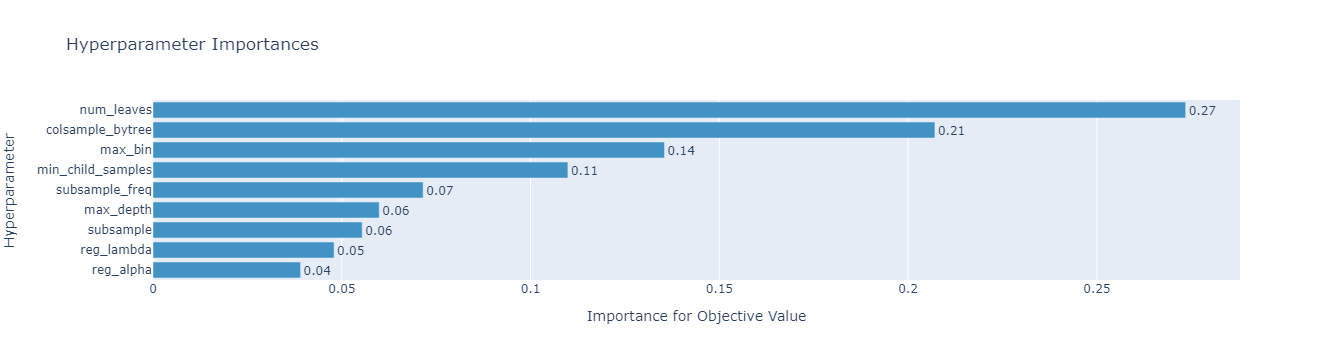

In [40]:
optuna.visualization.plot_param_importances(study)
# 하이퍼파라미터의 importance를 보여줌.

### 분포확인 (Visualization)

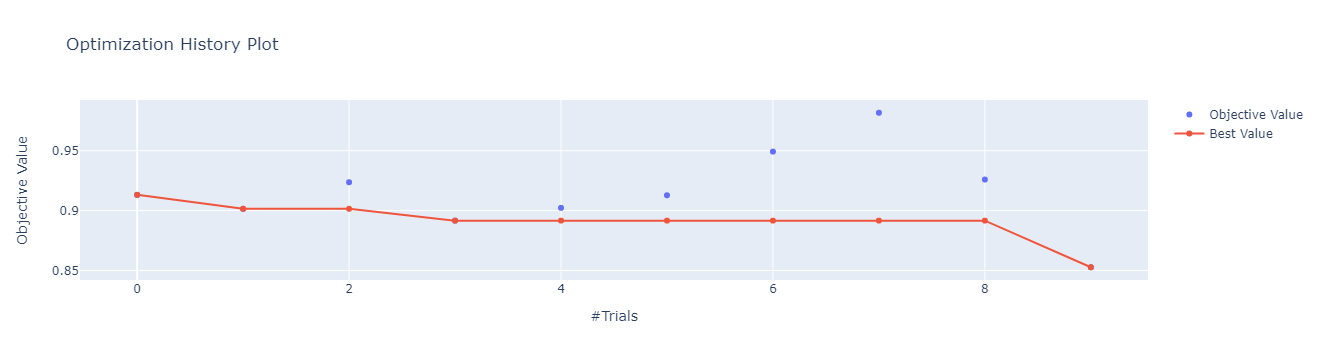

In [41]:
optuna.visualization.plot_optimization_history(study)
# 10개의 케이스 베스트값, 오브젝트값 전체적인 경향성을 볼 수 있음.

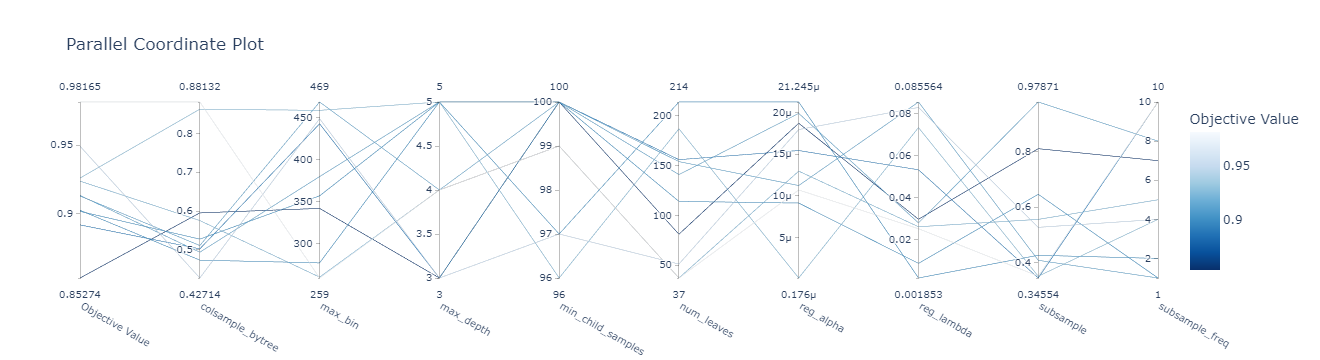

In [42]:
optuna.visualization.plot_parallel_coordinate(study)

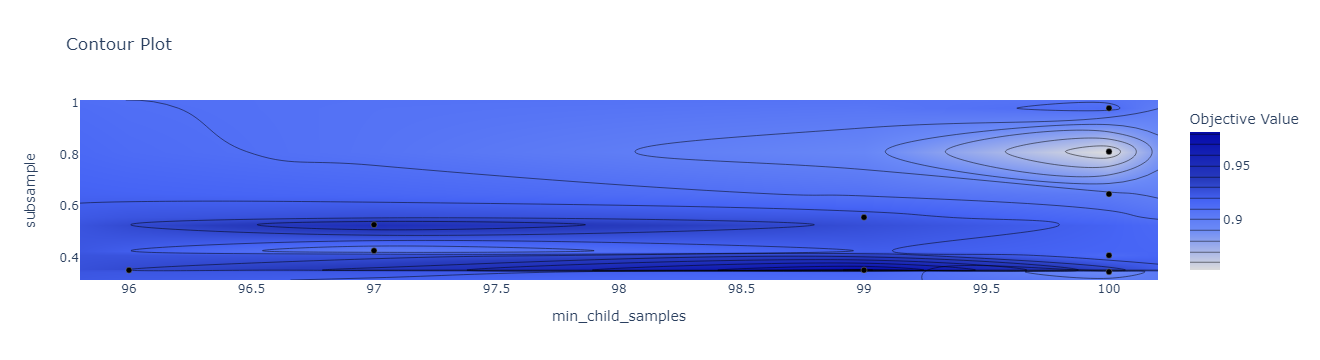

In [43]:
optuna.visualization.plot_contour(
    study,
    params=[
        "min_child_samples",
        "subsample",
#         "colsample_bytree",
#         "subsample",
#         "subsample_freq",
#         "min_child_samples",
#         "max_bin",
    ],
) 

# 'reg_alpha': 1.8702710823558463e-05, 'reg_lambda': 0.02978082892775818, 'max_depth': 3,
#             'num_leaves': 81, 'colsample_bytree': 0.5951099932160482, 'subsample': 0.8107243248366449
#                         , 'subsample_freq': 7, 'min_child_samples': 90, 'max_bin': 342
# Bayesian Optimization. 최적화공감에 대해 감을 가지고 있음.

## RandomForest best parmas 찾기

In [18]:
def objective(trial):
    params_rf = {
        "random_state": 42,
        "n_estimators": 10000,
#         "objective": "multiclass",
#         "metric": "multi_logloss",
        "min_samples_split" : trial.suggest_int("min_samples_split",2,10),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf",2,10),
        "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",2,10),
        "max_features": trial.suggest_float("max_features", 0, 1),
        "max_depth" : trial.suggest_int("max_depth",1,5),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,stratify=y)

    model = RandomForestClassifier(**params_rf)
    model.fit(
        X_train,
        y_train,
#         eval_set=[(X_train, y_train), (X_valid, y_valid)], 
#         early_stopping_rounds=100, # 100정도 성능향상이 없으면 끝냄
#         verbose=False,
    )

    rf_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, rf_pred)
    
    return log_score

In [19]:
sampler = TPESampler(seed=42)

study = optuna.create_study(           
    study_name="rf_parameter_opt",  # 맘대로 지정해줘도 됨.
    direction="minimize",    # 어떤 방향으로 최소화 (logloss는 최소화가 정답)
    sampler=sampler,
)

study.optimize(objective, n_trials=10) # objective (=logloss, 총 10가지에 대해 살펴볼거다.) 

print("Best Score:", study.best_value) # log_loss 값
print("Best trial:", study.best_trial.params)

[I 2021-10-03 16:17:18,691] A new study created in memory with name: rf_parameter_opt
[I 2021-10-03 16:17:32,107] Trial 0 finished with value: 1.288146382364512 and parameters: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_leaf_nodes': 8, 'max_features': 0.5986584841970366, 'max_depth': 1}. Best is trial 0 with value: 1.288146382364512.
[I 2021-10-03 16:17:51,216] Trial 1 finished with value: 0.9591038718871391 and parameters: {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_leaf_nodes': 9, 'max_features': 0.6011150117432088, 'max_depth': 4}. Best is trial 1 with value: 0.9591038718871391.
[I 2021-10-03 16:18:02,544] Trial 2 finished with value: 1.3013530391464256 and parameters: {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 9, 'max_features': 0.21233911067827616, 'max_depth': 1}. Best is trial 1 with value: 0.9591038718871391.
[I 2021-10-03 16:18:16,286] Trial 3 finished with value: 1.1090856687922903 and parameters: {'min_samples_split': 3, 'min_sampl

Best Score: 0.9591038718871391
Best trial: {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_leaf_nodes': 9, 'max_features': 0.6011150117432088, 'max_depth': 4}


> best log_loss score
>> max_depth = 5

### Hyper-parameter Importance

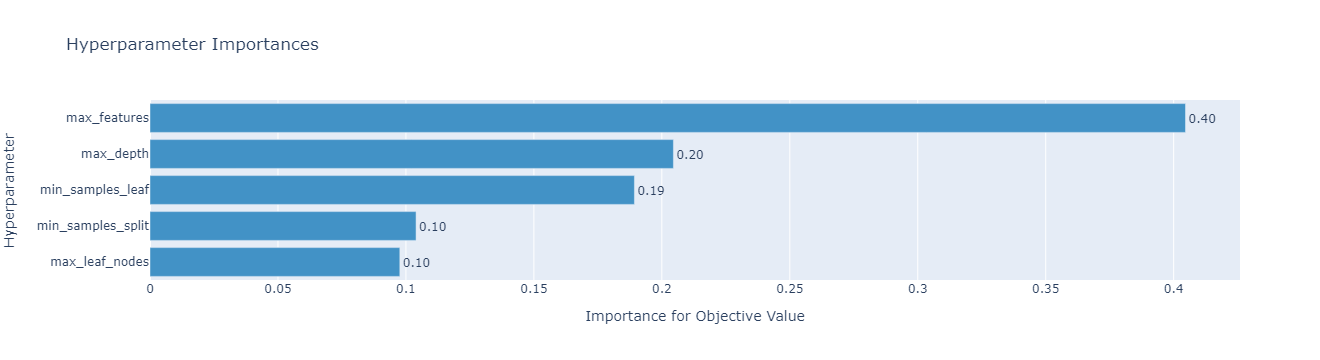

In [20]:
optuna.visualization.plot_param_importances(study)
# 하이퍼파라미터의 importance를 보여줌.

### 분포확인 (Visualization)

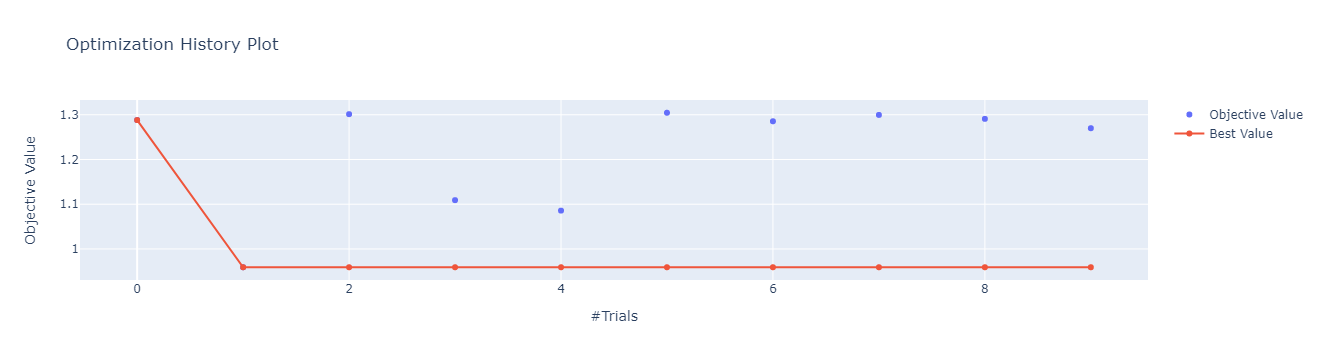

In [21]:
optuna.visualization.plot_optimization_history(study)
# 10개의 케이스 베스트값, 오브젝트값 전체적인 경향성을 볼 수 있음.

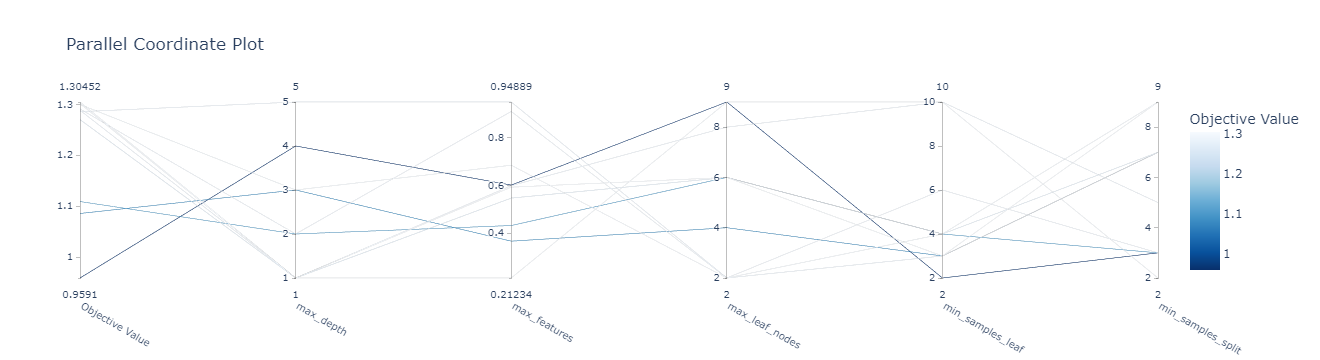

In [22]:
optuna.visualization.plot_parallel_coordinate(study)

In [25]:
# optuna.visualization.plot_contour(
#     study,
#     params=[
#         "max_depth",
#         "num_leaves",
#         "colsample_bytree",
#         "subsample",
#         "subsample_freq",
#         "min_child_samples",
#         "max_bin",
#     ],
# ) 
# Bayesian Optimization. 최적화공감에 대해 감을 가지고 있음.

---
## Extra Tree Classifier

In [26]:
def objective(trial):
    params_et = {
        "random_state": 42,
        "splitter" :'best',
#         "objective": "multiclass",
#         "metric": "multi_logloss",
        "min_samples_split" : trial.suggest_int("min_samples_split",2,100),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf",2,100),
        "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",2,100),
        "max_features": trial.suggest_float("max_features", 0, 1),
        "max_depth" : trial.suggest_int("max_depth",1,5),
    }
    

    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,stratify=y)

    model = ExtraTreeClassifier(**params_et)
    model.fit(
        X_train,
        y_train,
#         eval_set=[(X_train, y_train), (X_valid, y_valid)], 
#         early_stopping_rounds=100, # 100정도 성능향상이 없으면 끝냄
#         verbose=False,
    )

    et_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, et_pred)
    
    return log_score

In [27]:
sampler = TPESampler(seed=42)

study = optuna.create_study(           
    study_name="et_parameter_opt",  # 맘대로 지정해줘도 됨.
    direction="minimize",    # 어떤 방향으로 최소화 (logloss는 최소화가 정답)
    sampler=sampler,
)

study.optimize(objective, n_trials=10) # objective (=logloss, 총 10가지에 대해 살펴볼거다.) 

print("Best Score:", study.best_value) # log_loss 값
print("Best trial:", study.best_trial.params)

[I 2021-10-03 16:20:22,352] A new study created in memory with name: et_parameter_opt
[I 2021-10-03 16:20:22,363] Trial 0 finished with value: 1.376618103919128 and parameters: {'min_samples_split': 39, 'min_samples_leaf': 96, 'max_leaf_nodes': 74, 'max_features': 0.5986584841970366, 'max_depth': 1}. Best is trial 0 with value: 1.376618103919128.
[I 2021-10-03 16:20:22,376] Trial 1 finished with value: 1.2702819651107282 and parameters: {'min_samples_split': 17, 'min_samples_leaf': 7, 'max_leaf_nodes': 87, 'max_features': 0.6011150117432088, 'max_depth': 4}. Best is trial 1 with value: 1.2702819651107282.
[I 2021-10-03 16:20:22,383] Trial 2 finished with value: 1.3144988181954127 and parameters: {'min_samples_split': 4, 'min_samples_leaf': 98, 'max_leaf_nodes': 84, 'max_features': 0.21233911067827616, 'max_depth': 1}. Best is trial 1 with value: 1.2702819651107282.
[I 2021-10-03 16:20:22,391] Trial 3 finished with value: 1.2990912874897211 and parameters: {'min_samples_split': 20, 'min

Best Score: 1.0311073015558432
Best trial: {'min_samples_split': 62, 'min_samples_leaf': 18, 'max_leaf_nodes': 8, 'max_features': 0.9488855372533332, 'max_depth': 5}


> best log_loss score
>> max_depth = 5

### Hyper-parameter Importance ㅊ

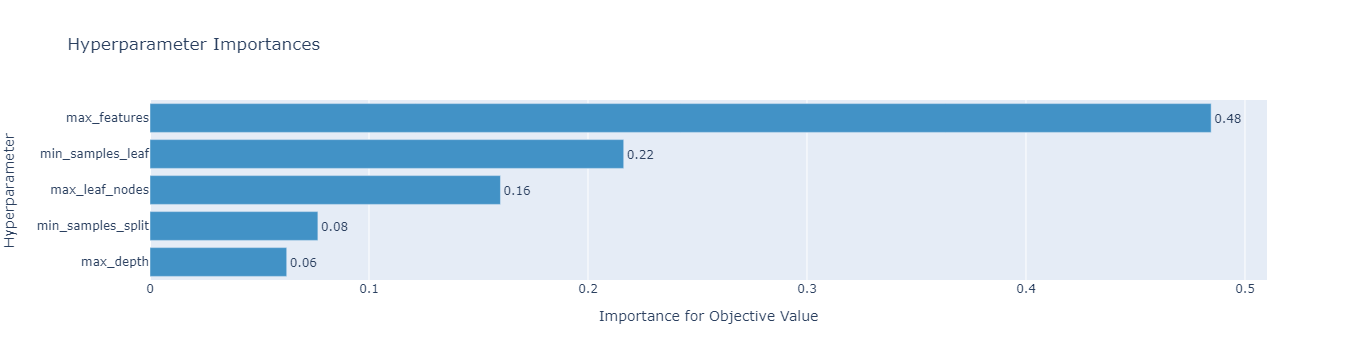

In [28]:
optuna.visualization.plot_param_importances(study)
# 하이퍼파라미터의 importance를 보여줌.

### 분포확인 (Visualization)

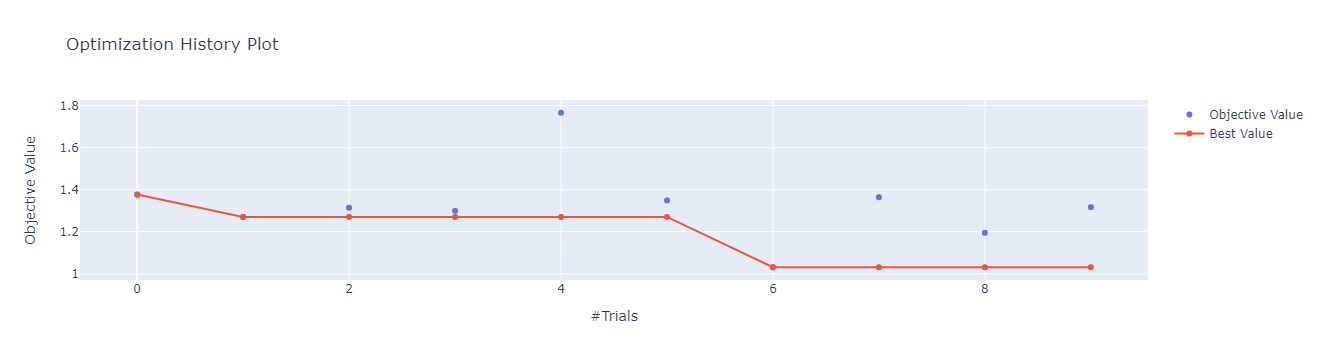

In [29]:
optuna.visualization.plot_optimization_history(study)
# 10개의 케이스 베스트값, 오브젝트값 전체적인 경향성을 볼 수 있음.

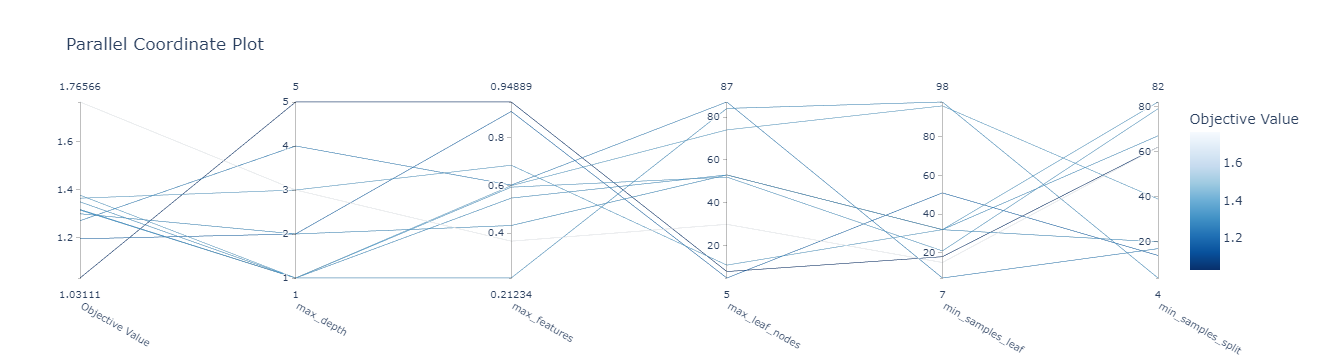

In [30]:
optuna.visualization.plot_parallel_coordinate(study)

In [31]:
# optuna.visualization.plot_contour(
#     study,
#     params=[
#         "max_depth",
#         "num_leaves",
#         "colsample_bytree",
#         "subsample",
#         "subsample_freq",
#         "min_child_samples",
#         "max_bin",
#     ],
# ) 
# # Bayesian Optimization. 최적화공감에 대해 감을 가지고 있음.

## 각각 predict_proba, feature importance 찾기

### lightgbm

In [ ]:
train = pd.read_csv('data/train3.csv')

In [ ]:
data = train.drop(['level'],axis=1)
data.head()

In [ ]:
import lightgbm as lgbm

In [ ]:
print(lgbm.__version__)

In [ ]:
from sklearn.model_selection import train_test_split
ohe = OneHotEncoder(sparse=False) 
target_ohe = ohe.fit_transform(train['level'].values.reshape(-1, 1))


y = train['level'].values
X = data

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lgbc = lgbm.LGBMClassifier()
%time lgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

pred = lgbc.predict_proba(X_train)
print('X_train lgbm logloss\n',log_loss(ohe.transform(y_train.reshape(-1, 1)), pred))

# lgbm 성능
pred = lgbc.predict_proba(X_val)
print('X_val lgbm logloss\n',log_loss(ohe.transform(y_val.reshape(-1, 1)), pred))



In [ ]:
df = pd.DataFrame(columns=["Feature", "Importance"])
df["Feature"] = X.columns
df["Importance"] = lgbc.feature_importances_
df.sort_values("Importance", axis=0, ascending=False, inplace=True)

x = np.arange(0, len(df["Feature"]))
height = 0.4

fig, ax = plt.subplots(figsize=(16, 30))
ax.barh(x, df["Importance"], height=height, edgecolor="black")

ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(x)
ax.set_yticklabels(df["Feature"], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
ax.invert_yaxis()
ax.margins(0.04, 0.01)
plt.show()

---
### rf

---
### et

## 앙상블 최적값 찾기